# Apache Sedona Tutorial - Spatial Join

This tutorial shows you how to create & analyse geospatial dataframes in Spark using Apache Sedona; as well as visualise the results

---

### Process
1. Initialise a Spark session with Sedona enabled
2. Load boundary & point dataframes from parquet files
3. Convert them to geospatial dataframes
4. Perform a spatial join
    - Fix the performance
5. Export the result to a Geopandas dataframe
6. Map the points, coloured by boundary type

---

### Data Used

- Boundary data is the ABS 2016 Census Remoteness Areas
- Point data is a randomised set of points, based on ABS 2016 Census Meshblock centroids

© Australian Bureau of Statistics (ABS), Commonwealth of Australia



---

### Import packages and set parameters

In [1]:
# import Python packages

import os

from multiprocessing import cpu_count

from pyspark.sql import functions as f
from sedona.spark import *

In [2]:
# set input path for parquet files
input_path = os.path.join(os.getcwd(), "data")
print(input_path)

# set max number of processes (defaults to number of physical CPUs)
num_processors = cpu_count()

/Users/hughsaalmans/git/iag_geo/spark_testing/apache_sedona/data


### Create the Spark session

In [3]:
config = (SedonaContext
          .builder()
          .master("local[*]")
          .appName("Sedona Test")
          .config("spark.sql.session.timeZone", "UTC")
          .config("spark.sql.debug.maxToStringFields", 100)
          .config("spark.sql.adaptive.enabled", "true")
          .config("spark.serializer", KryoSerializer.getName)
          .config("spark.kryo.registrator", SedonaKryoRegistrator.getName)
          .config("spark.executor.cores", 1)
          .config("spark.cores.max", num_processors)
          .config("spark.driver.memory", "4g")
          .config("spark.driver.maxResultSize", "2g")
          .getOrCreate()
          )

# Add Sedona functions and types to Spark
spark = SedonaContext.create(config)

print("Pyspark {} session initialised".format(spark.version))

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/10 16:07:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Pyspark 3.5.1 session initialised


### Load geospatial dataframes

#### 1. Load boundary data from gzipped parquet files

Boundary geometries are polygons stored in a GeoParquet file.

In [5]:
bdy_df = spark.read.format("geoparquet").load(os.path.join(input_path, "boundaries"))
bdy_df = bdy_df.repartition(96, "state")
bdy_df.printSchema()
bdy_df.show(5)

print("Loaded {} records".format(bdy_df.count()))

root
 |-- bdy_id: string (nullable = true)
 |-- bdy_type: string (nullable = true)
 |-- state: string (nullable = true)
 |-- geom: geometry (nullable = true)

+------+--------------------+---------------+--------------------+
|bdy_id|            bdy_type|          state|                geom|
+------+--------------------+---------------+--------------------+
|    12|Outer Regional Au...|New South Wales|POLYGON ((143.438...|
|    13|    Remote Australia|New South Wales|POLYGON ((141.364...|
|    13|    Remote Australia|New South Wales|POLYGON ((141.073...|
|    13|    Remote Australia|New South Wales|POLYGON ((141.146...|
|    13|    Remote Australia|New South Wales|POLYGON ((141.145...|
+------+--------------------+---------------+--------------------+
only showing top 5 rows

Loaded 17498 records


24/06/10 16:08:01 WARN GeoParquetFileFormat: GeoParquet currently does not support vectorized reader. Falling back to parquet-mr
24/06/10 16:08:01 WARN GeoParquetFileFormat: GeoParquet currently does not support vectorized reader. Falling back to parquet-mr
24/06/10 16:08:01 WARN GeoParquetFileFormat: GeoParquet currently does not support vectorized reader. Falling back to parquet-mr
24/06/10 16:08:01 WARN GeoParquetFileFormat: GeoParquet currently does not support vectorized reader. Falling back to parquet-mr
24/06/10 16:08:01 WARN GeoParquetFileFormat: GeoParquet currently does not support vectorized reader. Falling back to parquet-mr
24/06/10 16:08:01 WARN GeoParquetFileFormat: GeoParquet currently does not support vectorized reader. Falling back to parquet-mr
24/06/10 16:08:01 WARN GeoParquetFileFormat: GeoParquet currently does not support vectorized reader. Falling back to parquet-mr
24/06/10 16:08:01 WARN GeoParquetFileFormat: GeoParquet currently does not support vectorized rea

In [6]:
# add bdy number (last character of bdy ID) to bdy type - to enable display ordering in map
bdy_df2 = bdy_df \
    .withColumn("bdy_type", f.concat(f.substring(bdy_df["bdy_id"], -1, 1), f.lit(" - "), bdy_df["bdy_type"]))

# show 5 rows ordered randomly
bdy_df2.orderBy(f.rand()).show(5)

+------+--------------------+---------------+--------------------+
|bdy_id|            bdy_type|          state|                geom|
+------+--------------------+---------------+--------------------+
|    44|4 - Very Remote A...|South Australia|POLYGON ((133.628...|
|    14|4 - Very Remote A...|New South Wales|POLYGON ((147.173...|
|    11|1 - Inner Regiona...|New South Wales|POLYGON ((149.038...|
|    32|2 - Outer Regiona...|     Queensland|POLYGON ((150.251...|
|    30|0 - Major Cities ...|     Queensland|POLYGON ((153.023...|
+------+--------------------+---------------+--------------------+
only showing top 5 rows



In [7]:
# Create a view of the DataFrame to enable SQL queries
bdy_df2.createOrReplaceTempView("bdy")

#### 2. Load point data

Points are stored in a GeoParquet file.

In [9]:
point_df = spark.read.format("geoparquet").load(os.path.join(input_path, "points"))
point_df = point_df.repartition(96, "state")
point_df.printSchema()
point_df.show(5, False)

print("Loaded {} records".format(point_df.count()))

# create view to enable SQL queries
point_df.createOrReplaceTempView("pnt")

root
 |-- point_id: string (nullable = true)
 |-- state: string (nullable = true)
 |-- geom: geometry (nullable = true)

+-----------+---------------+---------------------------------------------+
|point_id   |state          |geom                                         |
+-----------+---------------+---------------------------------------------+
|11205709200|New South Wales|POINT (143.41940832443532 -35.1679832325487) |
|11204816600|New South Wales|POINT (141.31063706751135 -34.07951382750932)|
|10836830000|New South Wales|POINT (141.27575377114005 -33.99117828209031)|
|10836910000|New South Wales|POINT (141.51989019300967 -34.17010795987342)|
|10836920000|New South Wales|POINT (141.5823376057257 -34.147966217253746)|
+-----------+---------------+---------------------------------------------+
only showing top 5 rows



24/06/10 16:08:31 WARN GeoParquetFileFormat: GeoParquet currently does not support vectorized reader. Falling back to parquet-mr
24/06/10 16:08:31 WARN GeoParquetFileFormat: GeoParquet currently does not support vectorized reader. Falling back to parquet-mr


Loaded 368255 records


### Run a spatial join to boundary tag the points

##### Note:
1. One of the dataframes will be spatially indexed automatically to speed up the query
2. It's an inner join; point records could be lost in coastal areas or where there are gaps in the boundaries

In [10]:
from datetime import datetime

start_time = datetime.now()

sql = """SELECT pnt.point_id,
                bdy.bdy_id,
                bdy.bdy_type,
                bdy.state,
                pnt.geom
         FROM pnt
         INNER JOIN bdy ON ST_Intersects(pnt.geom, bdy.geom)"""
join_df = spark.sql(sql) \
    .cache()  # cache can save processing time when calling the same dataframe more than once
join_df.printSchema()
join_df.show(5, False)

join_count = join_df.count()

print("Boundary tagged {} points".format(join_count))
print("Query took {}".format(datetime.now() - start_time))

root
 |-- point_id: string (nullable = true)
 |-- bdy_id: string (nullable = true)
 |-- bdy_type: string (nullable = true)
 |-- state: string (nullable = true)
 |-- geom: geometry (nullable = true)



24/06/10 16:08:40 WARN JoinQuery: UseIndex is true, but no index exists. Will build index on the fly.


+-----------+------+----------------------------+-----------------+----------------------------------------------+
|point_id   |bdy_id|bdy_type                    |state            |geom                                          |
+-----------+------+----------------------------+-----------------+----------------------------------------------+
|50016440000|51    |1 - Inner Regional Australia|Western Australia|POINT (115.1344618613581 -34.368661831990934) |
|50016430000|51    |1 - Inner Regional Australia|Western Australia|POINT (115.13379937685815 -34.371604585677154)|
|50016400000|51    |1 - Inner Regional Australia|Western Australia|POINT (115.13324912968925 -34.37594787778328) |
|50016410000|51    |1 - Inner Regional Australia|Western Australia|POINT (115.13373796667231 -34.372852459262134)|
|50016450000|51    |1 - Inner Regional Australia|Western Australia|POINT (115.13587650514451 -34.37678875503281) |
+-----------+------+----------------------------+-----------------+-------------

### Export result to Geopandas for visualisation

*Note: doesn't scale to big data*

In [11]:
import geopandas

# convert to Pandas dataframe first (ordered by bdy_type for better visualisation)
pandas_df = join_df.orderBy(f.desc("bdy_type")).toPandas()

# then convert to Geopandas dataframe
geopandas_df = geopandas.GeoDataFrame(pandas_df, geometry="geom")

geopandas_df

,point_id,bdy_id,bdy_type,state,geom
0,50121880000,54,4 - Very Remote Australia,Western Australia,POINT (113.87279 -28.91657)
1,50122040000,54,4 - Very Remote Australia,Western Australia,POINT (113.85759 -28.90558)
2,50122060000,54,4 - Very Remote Australia,Western Australia,POINT (113.85917 -28.88680)
3,50121960000,54,4 - Very Remote Australia,Western Australia,POINT (113.86111 -28.89863)
4,50121820000,54,4 - Very Remote Australia,Western Australia,POINT (113.87710 -28.91370)
...,...,...,...,...,...
367877,30451690000,30,0 - Major Cities of Australia,Queensland,POINT (153.09793 -26.38619)
367878,30451730000,30,0 - Major Cities of Australia,Queensland,POINT (153.09545 -26.38522)
367879,30451700000,30,0 - Major Cities of Australia,Queensland,POINT (153.09782 -26.38452)
367880,30451720000,30,0 - Major Cities of Australia,Queensland,POINT (153.09739 -26.38392)


### Map the result

<Axes: >

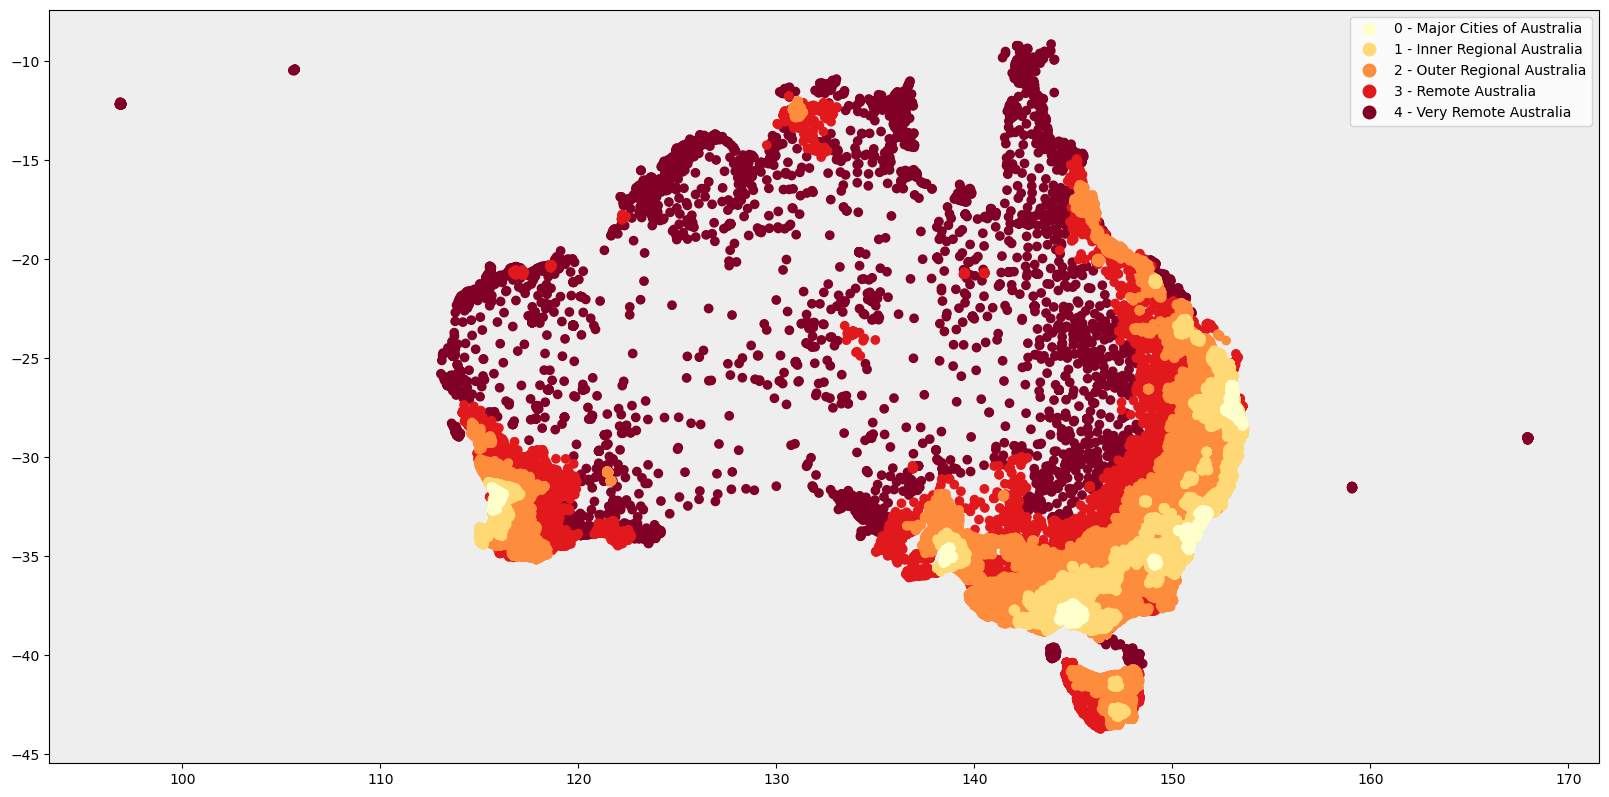

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(20, 20))

# set background colour
ax.set_facecolor('#EEEEEE')

# create map of points by bdy type
geopandas_df.plot(
    column="bdy_type",
    legend=True,
    cmap='YlOrRd',
    ax=ax
)

<Axes: >

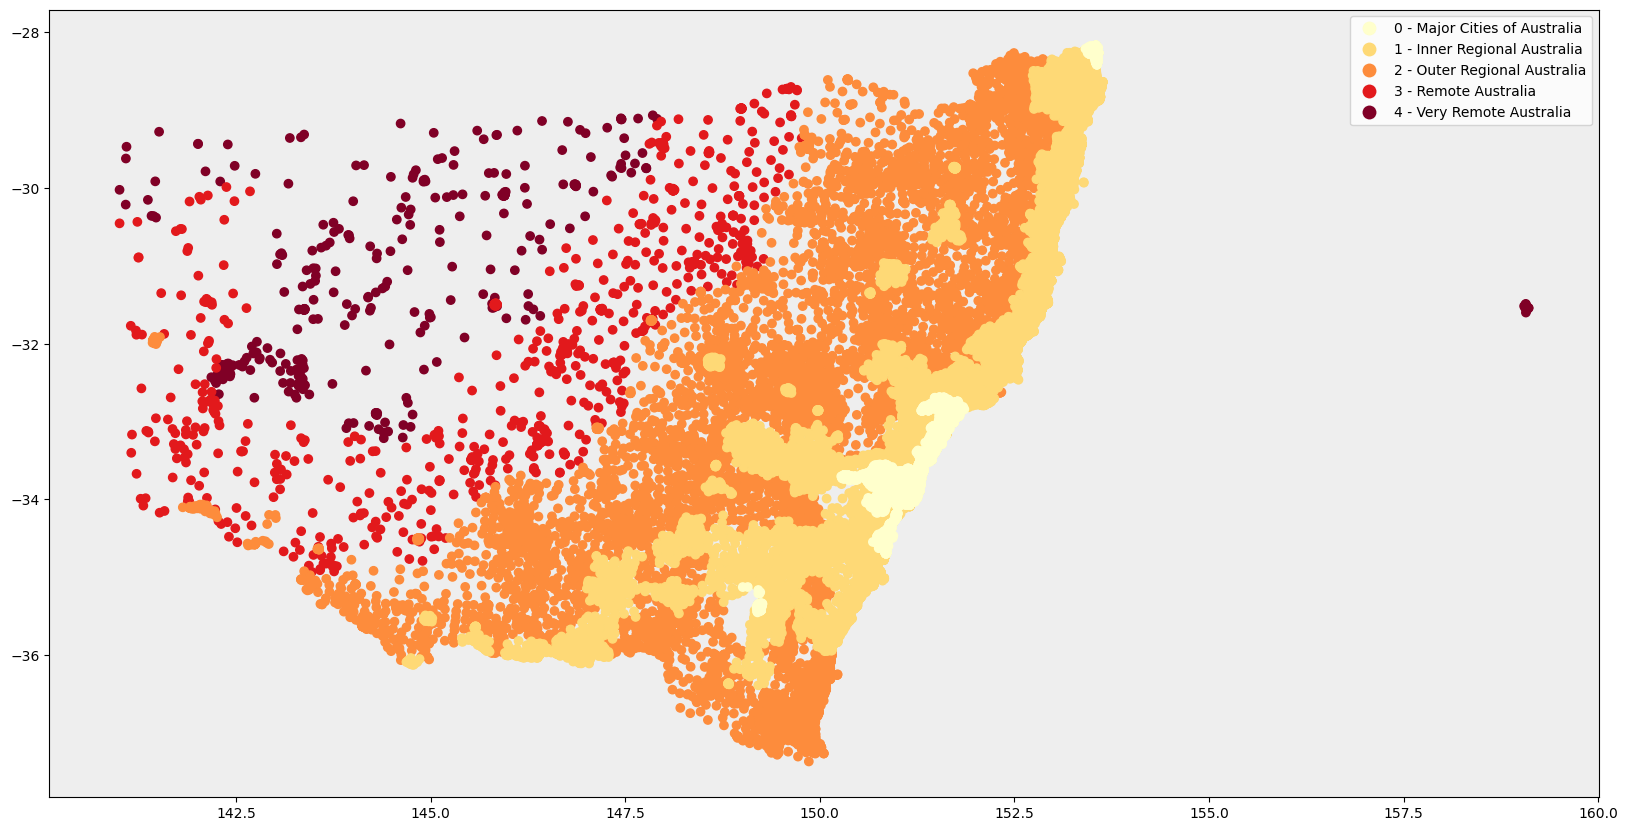

In [13]:
# map NSW only
fig2, ax2 = plt.subplots(1, figsize=(20, 20))
ax2.set_facecolor('#EEEEEE')

geopandas_df.loc[geopandas_df["state"] == "New South Wales"].plot(
    column="bdy_type",
    legend=True,
    cmap='YlOrRd',
    ax=ax2
)

### Close the Spark session

In [14]:
spark.stop()